In [27]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [7]:
directory = os.getcwd()
data = pd.read_csv(directory + '/EMS_2017_2018_cat_final.csv', sep=',') 

Boosting combines a set of weak learners and improves prediction accuracy. Model outcomes are weight based on outcomes of previous instant. Correct predictions are weighted lower, and misclassifed predictions are weighted higher.  (Weak learner is something that is slightly better than random guessing, ie. decision tree whose predictions are slightly better than 50%.)

Essentially:
1. Build weak model.
2. Make conclusions about various feature importance and params
3. Use conclusions to build new, stronger model and capitalize on misclassification error of previous model by trying to reduce it.

***Note:*** If planning on using XGBoost on dataset with categorical features, may need to apply encoding (like one-hot encoding) to features before training model.

In [3]:
pip install xgboost

  Using cached https://files.pythonhosted.org/packages/96/84/4e2cae6247f397f83d8adc5c2a2a0c5d7d790a14a4c7400ff6574586f589/xgboost-0.90.tar.gz
  Stored in directory: /Users/amandakuznecov/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost
Note: you may need to restart the kernel to use updated packages.


In [4]:
import xgboost as xgb

***Tuning Params:***

`learning_rate`: step size shrinkage used to prevent overfitting. Range is [0,1]

`max_depth`: determines how deeply each tree is allowed to grow during any boosting round.

`subsample`: percentage of samples used per tree. Low value can lead to underfitting.

`colsample_bytree`: percentage of features used per tree. High value can lead to overfitting.

`n_estimators`: number of trees you want to build.

`objective`: determines the loss function to be used like `reg:linear` for regression problems, `reg:logistic` for classification problems with only decision, `binary:logistic` for classification problems with probability.

***Regularization Support***:

`gamma`: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.

`alpha`: L1 regularization on leaf weights. A large value leads to more regularization.

`lambda`: L2 regularization on leaf weights and is smoother than L1 regularization.

In [13]:
data = data.drop(columns = ["INCIDENT_DATETIME","FIRST_ASSIGNMENT_DATETIME","FIRST_ACTIVATION_DATETIME","FIRST_ON_SCENE_DATETIME"])

In [14]:
X = data.drop(columns = ["INCIDENT_TRAVEL_TM_SECONDS_QY"])
Y = data["INCIDENT_TRAVEL_TM_SECONDS_QY"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

In [37]:
data_dmatrix = xgb.DMatrix(data=X,label=Y)

***XGB MODEL***

In [17]:
#reg:linear has been renamed to reg:squarederror
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100)

In [18]:
xg_reg.fit(X_train,Y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

***Model Predictions***

In [19]:
Y_pred = xg_reg.predict(X_test)

In [20]:
Y_pred

array([ 444.4237 ,  531.4791 ,  738.058  , ...,  243.68974,  418.4668 ,
       1008.1677 ], dtype=float32)

In [30]:
rmse = np.sqrt(mean_squared_error(Y_test,Y_pred))
rmse

69.08416906051885

In [24]:
vals = pd.DataFrame({"Actual": Y_test,"Predicted": Y_pred})
vals.head()

,Actual,Predicted
246687,451.0,444.423706
1668141,521.0,531.479126
593535,793.0,738.057983
2076078,463.0,451.495453
2498396,591.0,636.408203


***RESIDUALS***

In [29]:
vals["residuals"] = vals["Actual"]-vals["Predicted"]
vals.head()

,Actual,Predicted,residuals
246687,451.0,444.423706,6.576294
1668141,521.0,531.479126,-10.479126
593535,793.0,738.057983,54.942017
2076078,463.0,451.495453,11.504547
2498396,591.0,636.408203,-45.408203


In [25]:
from scipy import stats

(array([5.00000e+01, 6.81375e+05, 1.19600e+03, 3.40000e+01, 9.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-2130.92138672,  -812.04272461,   506.8359375 ,  1825.71459961,
         3144.59326172,  4463.47192383,  5782.35058594,  7101.22924805,
         8420.10791016,  9738.98657227, 11057.86523438]),
 <a list of 10 Patch objects>)

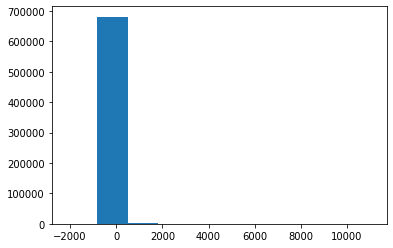

In [31]:
plt.hist(vals["residuals"])

((array([-4.75034493, -4.56777927, -4.46899308, ...,  4.46899308,
          4.56777927,  4.75034493]),
  array([-2130.92138672, -1885.02929688, -1835.95947266, ...,
          6467.61987305,  8299.42626953, 11057.86523438])),
 (48.74028354597713, 0.03772946290702196, 0.7055151706965692))

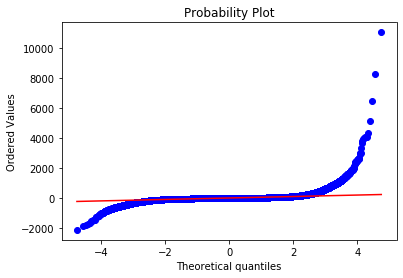

In [32]:
stats.probplot(vals["residuals"],plot=plt)

***Relationship between Residuals & Predictors***

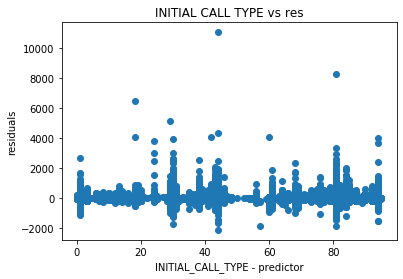

In [33]:
plt.scatter(X_test["INITIAL_CALL_TYPE"],vals["residuals"])
plt.xlabel("INITIAL_CALL_TYPE - predictor")
plt.ylabel("residuals")
plt.title("INITIAL CALL TYPE vs res")
plt.show()

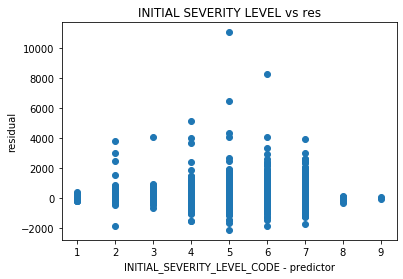

In [34]:
plt.scatter(X_test["INITIAL_SEVERITY_LEVEL_CODE"],vals["residuals"])
plt.xlabel("INITIAL_SEVERITY_LEVEL_CODE - predictor")
plt.ylabel("residual")
plt.title("INITIAL SEVERITY LEVEL vs res")
plt.show()

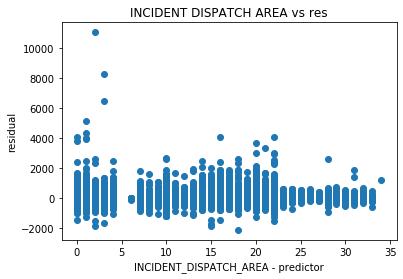

In [35]:
plt.scatter(X_test["INCIDENT_DISPATCH_AREA"],vals["residuals"])
plt.xlabel("INCIDENT_DISPATCH_AREA - predictor")
plt.ylabel("residual")
plt.title("INCIDENT DISPATCH AREA vs res")
plt.show()

***Visualizing Boosting Trees and Feature Importance***

In [41]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

In [42]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [44]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

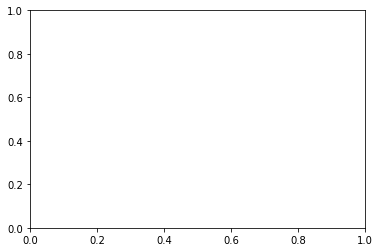

In [45]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()